In [75]:
import math

import numpy as np
import skimage.metrics as skm
import torch
from torchvision import transforms as T

from core.Transforms import image_normalization
from core.VariationalModelSolver import variational_model_solver
from core.img_utils import ImageLoader, plot_image
from core.kernels import gaussian_kernel_generator
from patchNr.Operators import BlurOperator
from patchNr.PatchFlowModel import PatchFlowModel
from patchNr.PatchNrRegulariser import PatchNrRegulariser

In [76]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cpu


In [77]:
patchNrFlowModel = PatchFlowModel(path='results/patch_nr/custom_patch_nr/version_3/custom_patch_nr_final.pth')

In [78]:
patch_size = int(math.sqrt(patchNrFlowModel.hparams['dimension']))

In [79]:
patch_nr_regulariser = PatchNrRegulariser(patchNrFlowModel, p_size=patch_size, sample_number=50000, padding=True, padding_size=8, device=DEVICE)

In [80]:
kernel_size = 9
std = 5

In [81]:
gaussian_kernel = gaussian_kernel_generator(kernel_size, std).to(DEVICE)
blur_operator = BlurOperator(gaussian_kernel, device=DEVICE)

In [82]:
normalization = T.Compose([image_normalization()])
image_loader = ImageLoader('data/material_pt_nr/test.png', device=DEVICE, transform=normalization)
ground_truth = image_loader[0].to(DEVICE)

In [57]:
degraded_image = blur_operator(ground_truth)
c, w, h = degraded_image.shape

In [58]:
sigma = 0.1
mu = 0
noise_level = 5.
error_dim = w*h
noise_vector_std1 = torch.reshape(torch.tensor(np.random.normal(mu, sigma, error_dim), device=DEVICE), (1, w, h))
noise_degraded_image = degraded_image + normalization(noise_vector_std1*noise_level)

In [59]:
startpoint = noise_degraded_image.clone()

In [60]:
psnr_rec = []

In [63]:
lam = 0.87
steps = 1
regulariser = patch_nr_regulariser

In [64]:
result = variational_model_solver(noise_degraded_image, startpoint, blur_operator, regulariser=regulariser, lam=lam, steps=steps, device=DEVICE)

Loss: -47.024230432219284; Likelihood: 92.49520926504634 R: -160.36717224121094: 100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


In [65]:
reconstructed_image, losses, likelihoods, regularisation = result

In [66]:
rec_img = reconstructed_image.detach().cpu()
deg_img = degraded_image.detach().cpu()
gt_img = ground_truth.cpu()

In [67]:
plot_sel_patch_pos = (330, 330)
plot_patch_size = 50

In [68]:
name = 'custom_patch_nr_material'

In [69]:
np.save(f'results/deblurring/{name}/custom_deblurring_result_lam_{lam}_k_{9}_std_{2}.npy', rec_img.numpy())

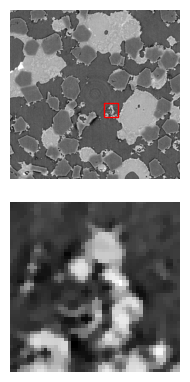

In [70]:
plot_image(f'results/deblurring/{name}/ground_truth.png', ground_truth, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

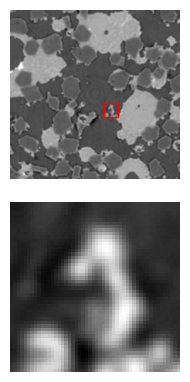

In [71]:
plot_image(f'results/deblurring/{name}/orig_degraded_input_noise_{noise_level}_k_{kernel_size}_std_{std}.png', noise_degraded_image, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

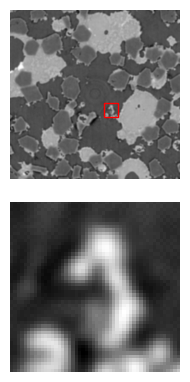

In [72]:
plot_image(f'results/deblurring/{name}/orig_reconstructed_custom_noise_{noise_level}_k_{kernel_size}_std_{std}_lam_{lam}.png', rec_img, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

In [73]:
psnr_rec = skm.peak_signal_noise_ratio(gt_img.numpy(), rec_img.numpy())
mse_rec = skm.mean_squared_error(gt_img.numpy(), rec_img.numpy())
psnr_deg = skm.peak_signal_noise_ratio(gt_img.numpy(), deg_img.numpy())
mse_deg = skm.mean_squared_error(gt_img.numpy(), deg_img.numpy())

print(f'PSNR rec: {psnr_rec}, PSNR deg: {psnr_deg}')
print(f'MSE rec: {mse_rec}, MSE deg: {mse_deg}')

PSNR rec: 25.686027278562985, PSNR deg: 25.48138330189257
MSE rec: 0.002700208326499079, MSE deg: 0.002830490292836813
